In [1]:
# prerequisites:
# pip install -U swifter[groupby]
import swifter 

import pandas as pd
import numpy as np
import h5py 
import matplotlib.pyplot as plt
from scipy.stats import uniform
from sklearn import linear_model
import pickle


In [2]:
# HYPER-PARAMETERS 
NOISE_FACTOR = 2  # кол-во шумовых фотонов по отношению к правильным
MINIMUM_FOTONS_NUMBER = 4  # Не рассматриваем случаи с меньшим чем MINIMUM_FOTONS_NUMBER числом фотонов
NUMBER_OF_CASES = 1000 # Кол-во случаев для оценки
BAND_WIDTH = 5 # Половина ширины полоски, в которой считаются фотоны
BAND_ROTATIONS_NUMBER = 100 # число поворотов для определения оптимального угла. минимальный угол поворота = 360гр/BAND_ROTATIONS_NUMBER 

In [3]:
df = pd.read_hdf("./data/Out_fin_pad(200)_x(-1.0,1.0)_E(0.01,10000.0)_eff(0.8)_102.h5")

In [4]:
svm = pickle.load(open("RBF SVM.model", "rb"))

In [5]:
# генерирует шум
def generate_uniform(size):
    xarr = uniform.rvs(scale = 199, size = size)
    yarr = uniform.rvs(scale = 199, size = size)
    return pd.DataFrame({'x_det_pad': xarr.astype(int), 'y_det_pad': yarr.astype(int)})

In [6]:
# определяет, лежит ли точка (px,py) в (верхней) полуплоскости, образуемой прямой, проходящей через (x0,y0), (x1,y1)
def point_belongs_to_semiplane(x0,y0,x1,y1,px,py):
    return np.cross([x1-x0, y1-y0], [px-x0,py-y0]) >= 0

In [7]:
# определяет, лежит ли точка в полосе шириной +-width, проходящую через точку (x0,y0) под углом alpha
def point_belongs_to_band(px,py, x0,y0, alpha, width):
    x1 = x0 + np.cos(alpha)
    y1 = y0 + np.sin(alpha)
    
    width_x = - width * np.sin(alpha)
    width_y = width * np.cos(alpha)
    return (not point_belongs_to_semiplane(x0 + width_x, y0 + width_y,x1 + width_x, y1 + width_y, px, py) and
        point_belongs_to_semiplane(x0 - width_x, y0 - width_y,x1 - width_x, y1 - width_y, px, py) and
        not point_belongs_to_semiplane(x0 - width_x, y0 - width_y, x0 + width_x, y0 + width_y, px, py))

In [8]:
# считает кол-во фотонов, попадающих в полосу шириной +-width, 
# проходящую через точку (x0,y0) под углом alpha
def count_points_in_band(df, x0, y0, alpha, width):         
    x1 = x0 + np.cos(alpha)
    y1 = y0 + np.sin(alpha)
    
    width_x = - width * np.sin(alpha)
    width_y = width * np.cos(alpha)
   
    count = 0   
    for index, row in df.iterrows():
        x = row['x_det_pad']
        y = row['y_det_pad']
        if (not point_belongs_to_semiplane(x0 + width_x, y0 + width_y,x1 + width_x, y1 + width_y, x, y) and
            point_belongs_to_semiplane(x0 - width_x, y0 - width_y,x1 - width_x, y1 - width_y, x, y) and
            not point_belongs_to_semiplane(x0 - width_x, y0 - width_y, x0 + width_x, y0 + width_y, x, y)
           ):
            count += 1
    
    return count

In [9]:
# считает кол-во фотонов в центрированном датасете, найденных svm классификатором, после поворота
def count_points_in_svm(XY, alpha, svm):         
    # матрица поворота
    R = np.transpose([
        [np.cos(alpha), np.sin(alpha)],
        [-np.sin(alpha),np.cos(alpha)]
    ])        
    return svm.predict(np.matmul(XY,R)).sum()

In [10]:
# находит оптимальный угол поворота для отдельного эксперимента путем полного перебора
def find_max_alfa(df, x0, y0, width):
    alpha_max = 0
    cmax = 0
    for alpha in np.arange(-np.pi, np.pi, 2*np.pi/BAND_ROTATIONS_NUMBER):
        c = count_points_in_band(df, x0, y0, alpha, width)
        if c > cmax:
            cmax = c
            alpha_max = alpha
            
    return alpha_max

In [11]:
# находит оптимальный угол поворота для отдельного эксперимента путем полного перебора
def find_max_alfa_svm(df, x0, y0, svm):
    # смещаем координаты
    XY = df[['x_det_pad','y_det_pad']] - [x0,y0]
   
    alpha_max = 0
    cmax = 0     
    for alpha in np.arange(-np.pi, np.pi, 2*np.pi/BAND_ROTATIONS_NUMBER):
        c = count_points_in_svm(XY, alpha, svm)
        if c > cmax:
            cmax = c
            alpha_max = alpha
            
    return alpha_max

In [12]:
# определяется ли точка svm классификатором, после преобразований координат и поворота
def point_belongs_to_svm(px, py, x0, y0, alpha, svm):
    XY = [[px - x0, py - y0]]
    # матрица поворота
    R = np.transpose([
        [np.cos(alpha), np.sin(alpha)],
        [-np.sin(alpha),np.cos(alpha)]
    ])
    return svm.predict(np.matmul(XY,R))[0]==1

In [13]:
# смещает и поворачивает данные отдельного
def rotate_data(df, x0, y0, alpha):          
    # смещаем и поворачиваем точки
    XY = df[['x_det_pad','y_det_pad']] - [x0,y0]
    # матрица поворота
    R = np.transpose([
        [np.cos(alpha), np.sin(alpha)],
        [-np.sin(alpha),np.cos(alpha)]
    ])      
    return np.matmul(XY,R)

In [14]:
# оцениваем точность метода для конкретного эксперимента
def evaluate_svm_method(df, svm, width):   
    # не рассматриваем случаи с малым числом фотонов
    if len(df) < MINIMUM_FOTONS_NUMBER:
        return
    
    # находим порождающую частицу
    particle = df.query('Eg == 0')
    # не рассматриваем случаи с двумя и более частицами
    if len(particle) > 1:
        return
    
    # находим координаты этой частицы
    x0 = float(particle.iloc[0]['x_det_pad'])
    y0 = float(particle.iloc[0]['y_det_pad'])
       
    # для оценки точности модели шум добавляем до определения угла поворота
    noise = generate_uniform(len(df) * NOISE_FACTOR)
    df_and_noise = pd.concat([df, noise])
    
    # определяем нужный угол поворота
    alpha_max = find_max_alfa(df_and_noise, x0, y0, width)
    #alpha_max = find_max_alfa_svm(df_and_noise, x0, y0, svm)
    
    df_and_noise[['x_det_pad', 'y_det_pad']] = rotate_data(df_and_noise, x0, y0, alpha_max)
    
    # считаем метрики
    TP = 0 # True Positive (TP): you predicted positive, the real value was positive
    TN = 0 # True Negative (TN): you predicted negative, the real value was negative
    FP = 0 # False Positive (FP): you predicted positive, the real value was negative
    FN = 0 # False Positive (FP): you predicted positive, the real value was negative
    for index, row in df_and_noise.iterrows():
        if row['Eg'] == 0: # саму частицу не учитываем
            continue
        if svm.predict([[row['x_det_pad'],row['y_det_pad']]])[0] == 1:
            if np.isnan(row['Num']):
                FP += 1
            else:
                TP += 1
        else:
            if np.isnan(row['Num']):
                TN += 1
            else:
                FN += 1
                  
    #return [TP, TN, FP, FN]
    return pd.DataFrame({'Num':[particle.iloc[0]['Num']], 'TP': [TP], 'TN': [TN], 'FP': [FP], 'FN': [FN]})

In [15]:
# группируем данные по номеру эксперимента, для каждой группы запускаем оценку
evaluation = df.query('Num < @NUMBER_OF_CASES').swifter.groupby("Num").apply(lambda x: evaluate_svm_method(x, svm, BAND_WIDTH))

  0%|          | 0/24 [00:00<?, ?it/s]

2023-12-10 17:48:20,939	INFO worker.py:1673 -- Started a local Ray instance.


In [16]:
evaluation

,,Num,TP,TN,FP,FN
Num,,,,,,
0.0,0,0.0,5,12,0,0
1.0,0,1.0,9,18,2,0
2.0,0,2.0,8,18,0,0
3.0,0,3.0,1,5,3,2
4.0,0,4.0,2,6,2,1
...,...,...,...,...,...,...
994.0,0,994.0,6,13,1,0
995.0,0,995.0,2,7,1,1
996.0,0,996.0,4,10,0,0


In [17]:
total = evaluation.sum()

In [18]:
# Evaluation metrics: https://www.edlitera.com/blog/posts/evaluating-classification-models

# 1. Доля правильных предсказаний - Accuracy
# Accuracy = (Number of correct predictions) / (Overall number of predictions)

# 2. Точность - Precision
# Precision = (True Positive) / (True Positive + False Positive)

# 3. Полнота - Recall (Sensitivity, True Positive Rate)
# The recall is defined as the number of true positives divided by the sum of true positives and false negatives. 
# It expresses the ability to find all relevant instances in a dataset. 
# Recall measures how good your model is at correctly predicting positive cases. 
# It’s the proportion of actual positive cases which were correctly identified. The equation for recall is:
# Recall = (True Positive) / (True Positive + False Negative)

Accuracy = (total['TP'] + total['TN']) / (total['TP'] + total['TN'] + total['FP'] + total['FN'])
Precision = total['TP'] / (total['TP'] + total['FP'])
Recall = total['TP'] / (total['TP'] + total['FN'])
print('NAIVE+SVM METHOD SCORE:')
print('Accuracy:', Accuracy)
print('Precision:', Precision)
print('Recall:', Recall)

NAIVE+SVM METHOD SCORE:
Accuracy: 0.9086720048345671
Precision: 0.7937219730941704
Recall: 0.9386363636363636


In [19]:
def plot_elements(df, low=0, up=200):
    fig, ax = plt.subplots(figsize=(4,4))
  
    plt.xlim(low,up)
    plt.ylim(low,up)
    particle = df.query('Eg == 0')
    df = df.drop(df[df.Eg == 0].index)
    
    data = df[df.Num.notnull()]
    noise = df[df.Num.isna()]
    
    ax.scatter(data[['x_det_pad']], data[['y_det_pad']], s=5, facecolor='blue')
    ax.scatter(noise[['x_det_pad']], noise[['y_det_pad']], s=1, facecolor='green')
    ax.scatter(particle[['x_det_pad']], particle[['y_det_pad']], facecolor='red', s=2)
    return fig, ax

In [20]:
def apply_svm_method(df, svm, width):   
    # находим порождающую частицу
    particle = df.query('Eg == 0')
   
    # находим координаты этой частицы
    x0 = float(particle.iloc[0]['x_det_pad'])
    y0 = float(particle.iloc[0]['y_det_pad'])
          
    # определяем нужный угол поворота
    alpha_max = find_max_alfa(df, x0, y0, width)
    #alpha_max = find_max_alfa_svm(df_and_noise, x0, y0, svm)
    
    fig, ax = plot_elements(df)
    df[['new_x', 'new_y']] = rotate_data(df, x0, y0, alpha_max)
    
    #fig1, ax1 = plot_elements(df_and_noise, -150, 150)
        
    # считаем метрики
    TP = 0 # True Positive (TP): you predicted positive, the real value was positive
    TN = 0 # True Negative (TN): you predicted negative, the real value was negative
    FP = 0 # False Positive (FP): you predicted positive, the real value was negative
    FN = 0 # False Positive (FP): you predicted positive, the real value was negative
    for index, row in df.iterrows():
        if row['Eg'] == 0: # саму частицу не учитываем
            continue
        if svm.predict([[row['new_x'],row['new_y']]])[0] == 1:
            if np.isnan(row['Num']):
                FP += 1
                ax.scatter([row['x_det_pad']], [row['y_det_pad']], s=10, facecolor='green')
            else:
                TP += 1
                ax.scatter([row['x_det_pad']], [row['y_det_pad']], s=10, facecolor='blue')
        else:
            if np.isnan(row['Num']):
                TN += 1
            else:
                FN += 1
                  
    #return [TP, TN, FP, FN]
    return pd.DataFrame({'Num':[particle.iloc[0]['Num']], 
                         'x0':x0,
                         'y0':y0,
                         'alpha_max':[alpha_max],
                         'TP': [TP], 'TN': [TN], 'FP': [FP], 'FN': [FN]})

In [21]:
df0 = df.query('Num == 44150')
df1 = pd.concat([df0, generate_uniform(len(df0) * NOISE_FACTOR)])

,Num,x0,y0,alpha_max,TP,TN,FP,FN
0,44150.0,133.0,101.0,3.078761,12,25,1,0


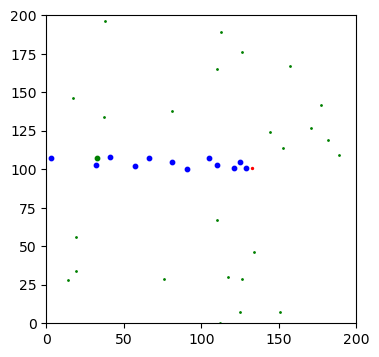

In [22]:
apply_svm_method(df1, svm, BAND_WIDTH)

In [23]:
import ray
ray.shutdown()